# Explore RoutineImmunization

In [48]:
import numpy as np
from laser.generic import SEIR
from laser.generic import Model
from laser.core.utils import grid
from laser.core import PropertySet
from laser.core import distributions
from laser.generic.newutils import ValuesMap
from laser.core.demographics import load_pyramid_csv
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator

POPULATION = 200_000
INITIAL_INFECTIONS = 100
ROWS = 1
COLS = 1
NNODES = ROWS * COLS

scenario = grid(M=ROWS, N=COLS, population_fn=lambda x, y: POPULATION // NNODES)
scenario["S"] = scenario.population - INITIAL_INFECTIONS
scenario["E"] = 0
scenario["I"] = INITIAL_INFECTIONS
scenario["R"] = 0

R0 = 7 # 1.125
exposure_mean = 7.0
exposure_scale = 1.0
infectious_mean = 10.0
infectious_scale = 1.5
beta = R0 / infectious_mean

NTICKS = 730
parameters = PropertySet({"nticks": NTICKS, "beta": beta})
birthrates = ValuesMap.from_scalar(35.0, NNODES, NTICKS).values

expdurdist = distributions.normal(loc=exposure_mean, scale=exposure_scale)
infdurdist = distributions.normal(loc=infectious_mean, scale=infectious_scale)

# https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=Population WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx
age_data = np.loadtxt("Nigeria-Distribution-2020.csv", delimiter=",", usecols=0)[0:89]  # Up to age 89 (largest value int16 can hold.)
pyramid = AliasedDistribution(age_data)

# https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=Mortality WPP2024_MORT_F04_1_LIFE_TABLE_SURVIVORS_BOTH_SEXES.xlsx
survival_data = np.loadtxt("Nigeria-Survival-2020.csv", delimiter=",", usecols=1)[0:89].cumsum() # Up to age 89 (largest value int16 can hold.)
survival = KaplanMeierEstimator(survival_data)


In [38]:
import matplotlib.pyplot as plt

def plot_traces(model, zoom=1.0, style=["-", "--"]):
    figure = plt.figure(figsize=(zoom*6, zoom*4.5))
    axes = [figure.add_subplot(1, 1, 1)]
    axes.append(axes[0].twinx())

    for channel, axis, color in [('S', 0, "blue"), ('E', 1, "orange"), ('I', 1, "red"), ('R', 0, "green")]:
        for node in range(model.nodes.count):
            data = getattr(model.nodes, channel)[:,node]
            label = f"Node {node} - {channel}"
            axes[axis].plot(data, label=label, color=color, linestyle=style[node % len(style)])

    axes[0].set_xlabel("Time (days)")
    axes[0].set_ylabel("Population")
    axes[1].set_ylabel("Population")
    axes[0].legend(loc="upper left")
    axes[1].legend(loc="upper right")
    axes[0].grid(True, which="both", axis="both", linestyle=":", linewidth=0.7, alpha=0.7, color="purple")
    axes[1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.7, alpha=0.7, color="orange")
    plt.tight_layout()
    plt.show()

    return

def print_summary(model):
    final_S = model.nodes.S[-1,:].sum()
    final_R = model.nodes.R[-1,:].sum()
    cumulative_infected = model.nodes.newly_infected.sum()
    print(f"Final Susceptible:   {final_S:7,}")
    print(f"Final Recovered:     {final_R:7,}")
    print(f"Cumulative Infected: {cumulative_infected:7,}")

baseline.people.count   =200,000
baseline.people.capacity=221,754


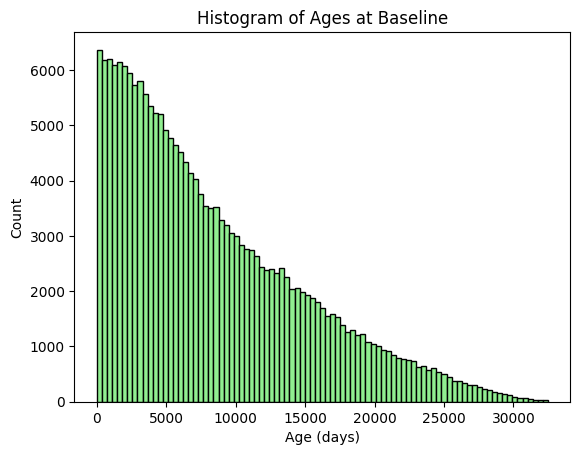

Ages range from 0 to 32484 days
Initially susceptible:           199,900
Initially over five:             168,992
Initially susceptible over five: 168,910
Remaining susceptible:            30,990 ( 30,990)


SEIR 1 Node(s) 2 Year No RI: 100%|██████████| 730/730 [00:00<00:00, 1090.92it/s]


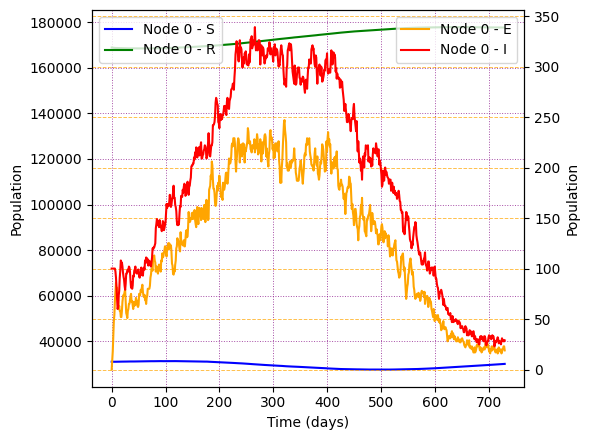

Final Susceptible:    30,035
Final Recovered:     177,691
Cumulative Infected:  13,461


In [49]:
from laser.generic.shared import State

baseline = Model(scenario, parameters, birthrates=birthrates, name="SEIR 2 Node 2 Year No RI")
baseline.components = [
    SEIR.Susceptible(baseline),
    SEIR.Recovered(baseline),
    SEIR.Infectious(baseline, infdurdist, infdurmin=1),
    SEIR.Exposed(baseline, expdurdist, infdurdist, expdurmin=1, infdurmin=1),
    SEIR.Transmission(baseline, expdurdist=expdurdist, expdurmin=1),
    SEIR.VitalDynamics(baseline, birthrates, pyramid, survival),
]

print(f"{baseline.people.count   =:7,}")
print(f"{baseline.people.capacity=:7,}")

def initialize_susceptibility(model, output: bool = False) -> None:

    # Mark everyone over age 5 and susceptible as recovered (not susceptible)
    now = 0
    ages = now - model.people.dob

    ##### ======== #####
    if output:
        nbins = (ages.max() + 1) // 365
        plt.hist(ages, bins=nbins, color="lightgreen", edgecolor="black")
        plt.xlabel("Age (days)")
        plt.ylabel("Count")
        plt.title("Histogram of Ages at Baseline")
        plt.show()
        print(f"Ages range from {ages.min()} to {ages.max()} days")
    ##### ======== #####

    susceptible = model.people.state == State.SUSCEPTIBLE.value
    over_five = ages >= 5*365
    susceptible_over_five = susceptible & over_five
    model.people.state[susceptible_over_five] = State.RECOVERED.value
    model.nodes.S[now,:] -= susceptible_over_five.sum()
    model.nodes.R[now,:] += susceptible_over_five.sum()
    remaining_susceptible = model.people.state == State.SUSCEPTIBLE.value
    if output:
        print(f"Initially susceptible:           {susceptible.sum():7,}")
        print(f"Initially over five:             {over_five.sum():7,}")
        print(f"Initially susceptible over five: {susceptible_over_five.sum():7,}")
        print(f"Remaining susceptible:           {remaining_susceptible.sum():7,} ({model.nodes.S[now,:].sum():7,})")

    return

initialize_susceptibility(baseline, output=True)

baseline.run(f"SEIR {NNODES} Node(s) 2 Year No RI")

plot_traces(baseline)
print_summary(baseline)

## Routine RI - 70% coverage, mean time to vaccination 9 months (274) days


200000 agents in 1 nodes: 100%|██████████| 730/730 [00:00<00:00, 848.01it/s]


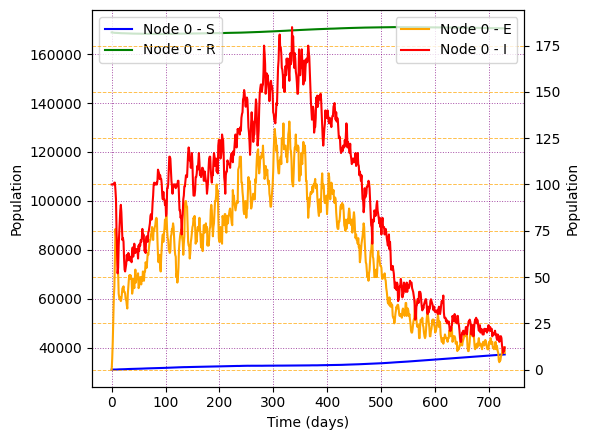

Final Susceptible:    37,176
Final Recovered:     170,571
Cumulative Infected:   6,524


In [50]:
from laser.generic.immunization import RoutineImmunizationEx

def run_with_ri(coverage_fn, dose_timing_dist=None, dose_timing_min=None, plot=True):
    model = Model(scenario, parameters, birthrates=birthrates, name="SEIR 2 Node 2 Year 70% RI")

    if dose_timing_dist is None:
        dose_timing_dist = distributions.normal(loc=274, scale=15)  # Around 9 months
    if dose_timing_min is None:
        dose_timing_min = 183  # Minimum 6 months

    model.components = [
        SEIR.Susceptible(model),
        SEIR.Recovered(model),
        SEIR.Infectious(model, infdurdist, infdurmin=1),
        SEIR.Exposed(model, expdurdist, infdurdist, expdurmin=1, infdurmin=1),
        SEIR.Transmission(model, expdurdist=expdurdist, expdurmin=1),
        SEIR.VitalDynamics(model, birthrates, pyramid, survival),
        RoutineImmunizationEx(model, coverage_fn=coverage_fn, dose_timing_dist=dose_timing_dist, dose_timing_min=dose_timing_min, track=True),
    ]

    initialize_susceptibility(model, output=False)

    model.run()
    if plot:
        plot_traces(model)
        print_summary(model)

    return model

coverage_constant = distributions.constant_float(value=0.7) # 70% coverage
model = run_with_ri(coverage_constant)


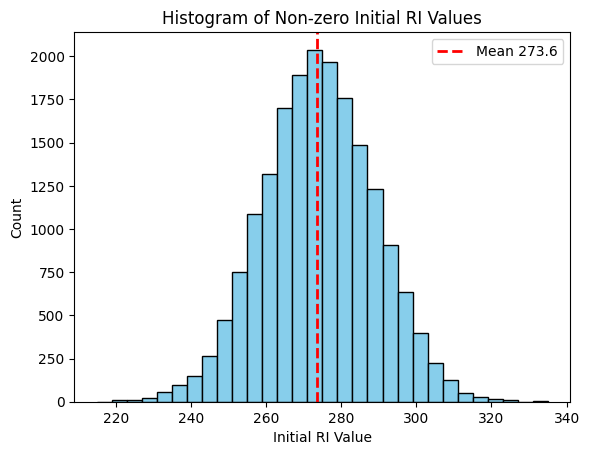

In [41]:
nonzero_initial_ri = model.people.initial_ri[model.people.initial_ri > 0]
plt.hist(nonzero_initial_ri, bins=30, color="skyblue", edgecolor="black")
plt.axvline(nonzero_initial_ri.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean {nonzero_initial_ri.mean():.1f}")
plt.legend()
plt.xlabel('Initial RI Value')
plt.ylabel('Count')
plt.title('Histogram of Non-zero Initial RI Values')
plt.show()